In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

import os
import random
from pathlib import Path

In [3]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

In [4]:
def get_all_frames(root_dir='data'):
    ### Получаем все jpg файлы из всех подкаталогов frames ###
    all_frames = []
    
    for root, dirs, files in os.walk(root_dir):
        if os.path.basename(root) == 'frames':
            jpg_files = [os.path.join(root, f) for f in files if f.lower().endswith('.jpg')]
            all_frames.extend(jpg_files)
    
    if not all_frames:
        raise ValueError("Не найдено ни одного jpg файла в структуре каталогов")
    
    return all_frames

all_frames = get_all_frames('/mnt/datasets')

In [8]:
try:
	random_frame = random.choice(all_frames)
	print(f"Random sample frame: {random_frame}")
except ValueError as e:
	print(e)

Random sample frame: /mnt/datasets/frames/2024_07_08__13_09_06__1720444786476.jpg


In [9]:
image = cv2.imread(random_frame)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

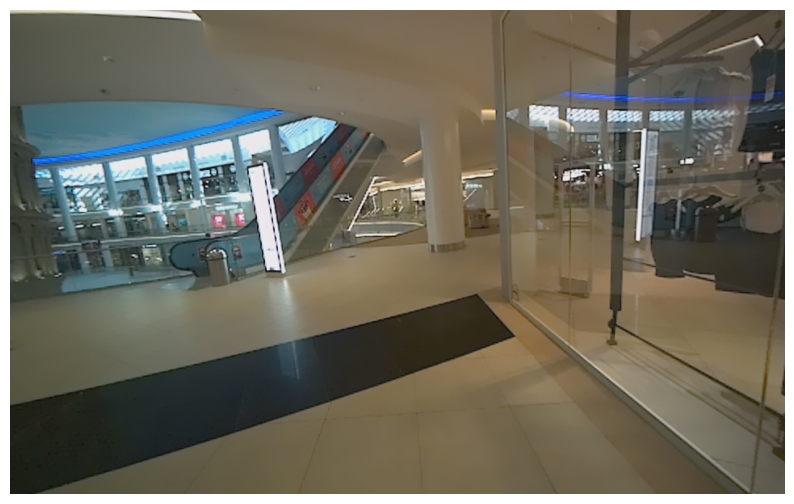

In [10]:
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('off')
plt.show()

In [13]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "/mnt/datasets/checkpoints/sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)
masks = mask_generator.generate(image)

In [14]:
# masks = mask_generator.generate(image)

In [14]:
print(len(masks))
print(masks[0].keys())

134
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


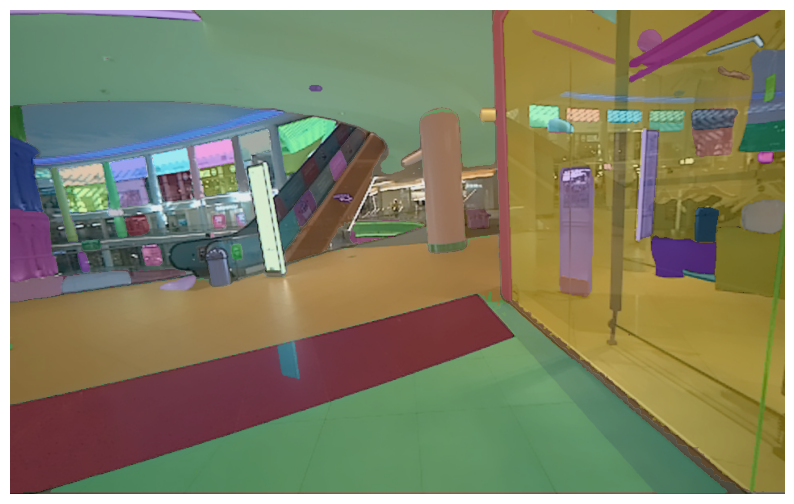

In [15]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show() 

In [16]:
def crop_by_mask(image, bbox):
    x, y, w, h = bbox
    return image[y:y+h, x:x+w]

Сохранено 101 кропов в директорию /home/oversir/dev/crops2024_07_08__13_09_06__1720444786476


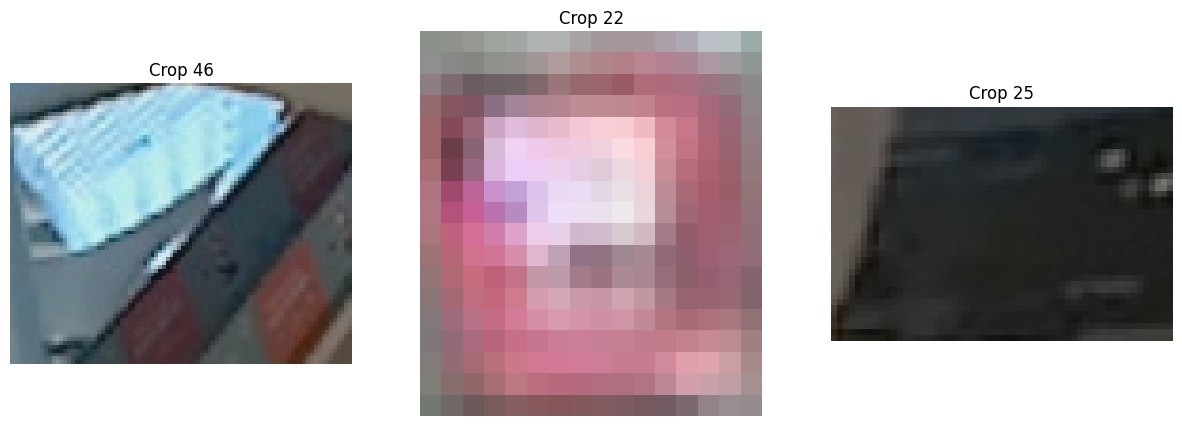

In [17]:
output_dir = Path('/home/oversir/dev/crops' + Path(random_frame).stem)
output_dir.mkdir(parents=True, exist_ok=True)

base_filename = Path(random_frame).stem

for idx, mask in enumerate(masks):
    bbox = mask['bbox']
    
    cropped_img = crop_by_mask(image, bbox)
    
    crop_filename = f"{base_filename}_crop_{idx}.jpg"
    crop_path = output_dir / crop_filename
    
    cropped_img_bgr = cv2.cvtColor(cropped_img, cv2.COLOR_RGB2BGR)
    cv2.imwrite(str(crop_path), cropped_img_bgr)

print(f"Сохранено {len(masks)} кропов в директорию {output_dir}")

plt.figure(figsize=(15, 5))
sample_crops = random.sample(range(len(masks)), min(3, len(masks)))
for i, idx in enumerate(sample_crops):
    plt.subplot(1, 3, i+1)
    bbox = masks[idx]['bbox']
    cropped = crop_by_mask(image, bbox)
    plt.imshow(cropped)
    plt.title(f'Crop {idx}')
    plt.axis('off')
plt.show()